In [1]:
import torch
import os

from PIL import Image
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

from dotenv import load_dotenv
load_dotenv()

# from huggingface_hub import login
# login(os.getenv("HF_TOKEN"))

# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)
# Load an image
image = Image.open("<image.png>")
inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt="<YOUR_TEXT_PROMPT>")

# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

KeyboardInterrupt: 

In [5]:
import os
import sam3
import torch

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

# use all available GPUs on the machine
# gpus_to_use = range(torch.cuda.device_count())
# # use only a single GPU
gpus_to_use = [torch.cuda.current_device()]

In [6]:
from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(gpus_to_use=gpus_to_use)

INFO 2025-11-21 17:28:16,787 86964 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-21 17:28:16,789 86964 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-21 17:28:16,789 86964 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-21 17:28:21,351 86964 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-11-21 17:28:24,342 86964 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-21 17:28:24,342 86964 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




In [9]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

In [10]:
video_path = f"input_videos/video_1.mp4"

In [11]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

In [12]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]:   0%|          | 0/117 [00:00<?, ?it/s]

frame loading (OpenCV) [rank=0]: 100%|██████████| 117/117 [00:00<00:00, 929.26it/s]


In [26]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

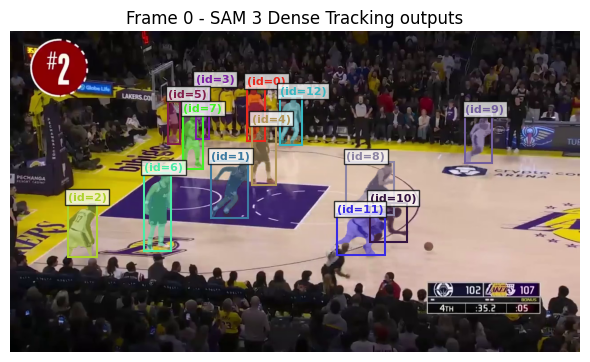

In [27]:
prompt_text_str = "basketball player on light team"
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

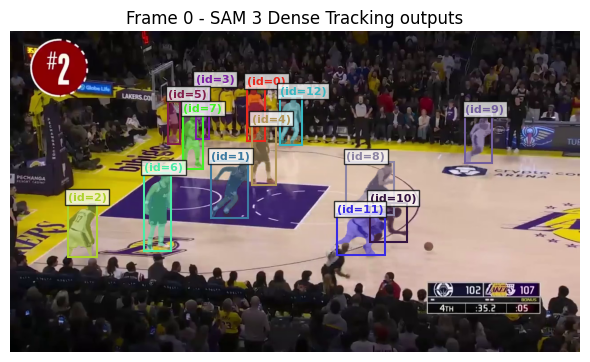

In [28]:

frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")

visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

  0%|          | 0/117 [00:00<?, ?it/s]

0it [00:00, ?it/s]

ValueError: not enough values to unpack (expected 2, got 1)

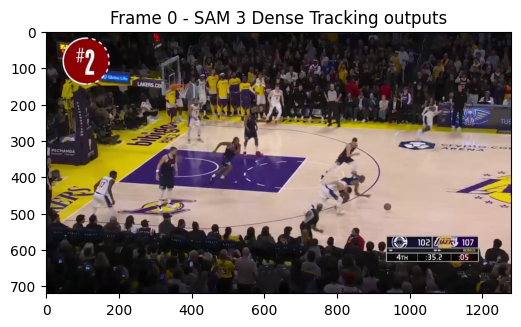

In [36]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
# outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 80
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [ ]:
def draw_mask(frame, mask, color=(0, 255, 0), alpha=0.2):
    overlay = frame.copy()
    overlay[mask] = color  # apply color only on masked region
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    return frame

def draw_frame(frame, frame_outputs):
    mask = frame_outputs["out_binary_masks"].any(axis=0)
    frame = draw_mask(frame, mask)
    return frame

def annotate_video(frames, outputs_per_frame):
    annotated_frames = []
    for i in outputs_per_frame.keys():
        annotated_frame = draw_frame(frames[i], outputs_per_frame[i])
        annotated_frames.append(annotated_frame)
    
    return annotated_frames

def save_video_from_frames(frames, output_path, fps=30):
    height, width = frames[0].shape[:2]

    # Create video writer (mp4)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        frame = np.asarray(frame)

        # Convert RGB → BGR if needed (OpenCV expects BGR)
        if frame.dtype != np.uint8:
            frame = frame.astype(np.uint8)

        if frame.shape[-1] == 3:
            # Heuristic: if it's RGB, convert to BGR
            # (Optional: remove if you're certain frames are already BGR)
            frame = frame[:, :, ::-1]

        out.write(frame)

    out.release()


In [50]:
print(outputs_per_frame)

{0: {'out_obj_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), 'out_probs': array([0.8241758 , 0.87096775, 0.68      , 0.80124223, 0.57755774,
       0.89041096, 0.83589745, 0.83589745, 0.60493827, 0.65217394,
       0.68      , 0.8160919 ], dtype=float32), 'out_boxes_xywh': array([[0.3515625 , 0.40416667, 0.0671875 , 0.17638889],
       [0.10078125, 0.53333336, 0.0515625 , 0.16666667],
       [0.32578126, 0.16388889, 0.02265625, 0.17083333],
       [0.4234375 , 0.2875    , 0.04140625, 0.18888889],
       [0.27812502, 0.21111111, 0.01953125, 0.1375    ],
       [0.23515625, 0.44166666, 0.04765625, 0.24166667],
       [0.30390626, 0.25694445, 0.0328125 , 0.17083333],
       [0.590625  , 0.40555558, 0.08203125, 0.16388889],
       [0.79843754, 0.25833333, 0.046875  , 0.1513889 ],
       [0.6328125 , 0.5361111 , 0.0640625 , 0.11944444],
       [0.5734375 , 0.5694445 , 0.084375  , 0.12777779],
       [0.47343752, 0.2013889 , 0.03828125, 0.1513889 ]], dtype=float32), 'out_bina

In [88]:
annotated_frames = annotate_video(video_frames_for_vis, outputs_per_frame)
save_video_from_frames(annotated_frames, "annotated_video.mp4")

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'addWeighted'
> Overload resolution failed:
>  - addWeighted() missing required argument 'gamma' (pos 5)
>  - addWeighted() missing required argument 'gamma' (pos 5)
